In [551]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import necessary modules from scikit-learn for pipline
from sklearn import set_config
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [552]:
trainset = pd.read_csv('./Dataset/LoanPrediction_TrainSet.csv')
testset = pd.read_csv('./DataSet/LoanPrediction_TestSet.csv')



# Data Exploration:

In [553]:
trainset.head(10)

,Unnamed: 0,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [554]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         614 non-null    int64  
 1   LoanID             614 non-null    object 
 2   Gender             601 non-null    object 
 3   Married            611 non-null    object 
 4   Dependents         599 non-null    object 
 5   Education          614 non-null    object 
 6   SelfEmployed       582 non-null    object 
 7   ApplicantIncome    614 non-null    int64  
 8   CoapplicantIncome  614 non-null    float64
 9   LoanAmount         592 non-null    float64
 10  LoanAmountTerm     600 non-null    float64
 11  CreditHistory      564 non-null    float64
 12  PropertyArea       614 non-null    object 
 13  LoanStatus         614 non-null    object 
dtypes: float64(4), int64(2), object(8)
memory usage: 67.3+ KB


### Analytics Base Table ABT

In [555]:

ABT_train = trainset.describe(include="all").T

ABT_train = ABT_train.reset_index().rename(columns={'index': 'Feature'})
ABT_train['Missing'] = trainset.isnull().sum().values
ABT_train['dtype'] = trainset.dtypes.values
ABT_train.to_excel('ABT_train.xlsx', index=False)
ABT_train


# Wrong data types for some features like 'Dependents' and 'Credit_History' and missing values in some features
# There is some unbalance in the target variable 'Loan_Status' 
# Dependents looks like it have some not allowed additions sign as well for 3+ as a category which i will fix
# Bias in features for example Gender more male and females


,Feature,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,dtype
0,Unnamed: 0,614.0,NaN,NaN,NaN,306.5,177.390811,0.0,153.25,306.5,459.75,613.0,0,int64
1,LoanID,614,614,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
2,Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,object
3,Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,object
4,Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,object
5,Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
6,SelfEmployed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,object
7,ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0,0,int64
8,CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0,0,float64
9,LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0,22,float64


# Top 5  highly correlated variables with the target variable ‘LoanStatus’

In [ ]:
# drop LoanID and Unnamed as it is not useful for prediction and not affect correlation
trainset = trainset.drop(columns=['LoanID',"Unnamed: 0"])
testset = testset.drop(columns=['LoanID',"Unnamed: 0"])

X_num = trainset.select_dtypes(include="number")
X_cat = pd.get_dummies(trainset.select_dtypes(exclude="number"), drop_first=True)
y = trainset['LoanStatus'].map({'Y':1, 'N':0})

X_eda = pd.concat([X_num, X_cat], axis=1)
corr = X_eda.corrwith(y)

corr.sort_values(ascending=False).head(6)

LoanStatus_Y              1.000000
CreditHistory             0.561678
PropertyArea_Semiurban    0.136540
Married_Yes               0.084281
Dependents_2              0.062384
Gender_Male               0.025407
dtype: float64

In [557]:
X_eda

,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,SelfEmployed_Yes,PropertyArea_Semiurban,PropertyArea_Urban,LoanStatus_Y
0,5849,0.0,NaN,360.0,1.0,True,False,False,False,False,False,False,False,True,True
1,4583,1508.0,128.0,360.0,1.0,True,True,True,False,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,True,True,False,False,False,False,True,False,True,True
3,2583,2358.0,120.0,360.0,1.0,True,True,False,False,False,True,False,False,True,True
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,360.0,1.0,False,False,False,False,False,False,False,False,False,True
610,4106,0.0,40.0,180.0,1.0,True,True,False,False,True,False,False,False,False,True
611,8072,240.0,253.0,360.0,1.0,True,True,True,False,False,False,False,False,True,True
612,7583,0.0,187.0,360.0,1.0,True,True,False,True,False,False,False,False,True,True


### Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

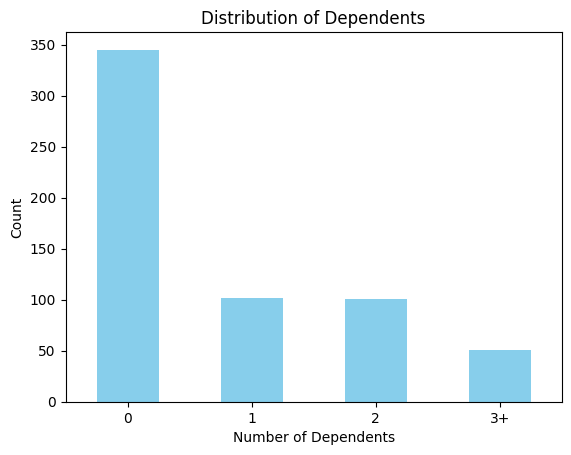

In [558]:
# Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

dependents_count = trainset['Dependents'].value_counts()
dependents_count.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')
plt.title('Distribution of Dependents')
plt.xticks(rotation=0)
plt.show()

# Data Pre-processing:

In [559]:
# fix dependents
trainset['Dependents'] = trainset['Dependents'].replace('3+', 3).astype(float)
testset['Dependents'] = testset['Dependents'].replace('3+', 3).astype(float)


X_train = trainset.drop(columns=['LoanStatus'])
y_train = trainset['LoanStatus'].map({'N':0, 'Y':1})

X_test = testset.drop(columns=['LoanStatus'])
y_test = testset['LoanStatus'].map({'N':0, 'Y':1})




 ## If Dependents isnt cleaned regarding data typ object and fixing 3+ got diffrent correlation where Gender wasnt not showing that it inbalanced

In [560]:
    """
LoanStatus                     1.000000
num__CreditHistory             0.540556
cat__PropertyArea_Semiurban    0.136540
cat__Married_Yes               0.091478
cat__Education_Graduate        0.085884
cat__Dependents_2              0.062384
Name: LoanStatus, dtype: float64
    """

'\nLoanStatus                     1.000000\nnum__CreditHistory             0.540556\ncat__PropertyArea_Semiurban    0.136540\ncat__Married_Yes               0.091478\ncat__Education_Graduate        0.085884\ncat__Dependents_2              0.062384\nName: LoanStatus, dtype: float64\n'

# Feature Engineering:

In [561]:
def feature_engineering(df):
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['InstalmentAmount'] = df['LoanAmount'] / df['LoanAmountTerm']
    df['BalancedIncome'] = df['TotalIncome'] - df['InstalmentAmount']
    return df

# Development of Predictive Models pipline:

In [562]:

set_config(transform_output="pandas")
num_select = make_column_selector(dtype_include=np.number)
cat_select = make_column_selector(dtype_include=object)

impute = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), num_select),
    ('cat', SimpleImputer(strategy='most_frequent'), cat_select),
], verbose_feature_names_out=False)

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocess = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_select),
    ('cat', cat_pipeline, cat_select)
],   verbose_feature_names_out=False)  

#investigate the preprocessed data
preprocess.fit(X_train)
X_train_processed = preprocess.transform(X_train)
feature = preprocess.get_feature_names_out()

X_train_proccessed = pd.DataFrame(X_train_processed, columns=feature)

X_train_proccessed



,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,Gender_Female,Gender_Male,Gender_nan,Married_No,Married_Yes,Married_nan,Education_Graduate,Education_Not Graduate,SelfEmployed_No,SelfEmployed_Yes,SelfEmployed_nan,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
0,-0.752131,0.072991,-0.554487,NaN,0.276642,0.432861,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.233704,-0.134412,-0.038732,-0.215309,0.276642,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.752131,-0.393747,-0.554487,-0.940328,0.276642,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.752131,-0.462062,0.251980,-0.308860,0.276642,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.752131,0.097728,-0.554487,-0.063289,0.276642,0.432861,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.752131,-0.410130,-0.554487,-0.881859,0.276642,0.432861,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
610,2.205374,-0.212557,-0.554487,-1.244368,-2.489775,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
611,0.233704,0.437174,-0.472404,1.246423,0.276642,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
612,1.219539,0.357064,-0.554487,0.474628,0.276642,0.432861,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [563]:

logistic_model= Pipeline(steps =[
    ('impute',impute),
    ('feature_engineering',FunctionTransformer(feature_engineering)),
    ('preprocess',preprocess),
    ('uppsamp', SMOTE()),
     ('model',LogisticRegression(max_iter=1000))
] )
logistic_model

                            


,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [564]:
decisiontree_model= Pipeline(steps =[
    ('impute',impute),
    ('feature_engineering',FunctionTransformer(feature_engineering)),
    ('preprocess',preprocess),
    ('uppsamp', SMOTE(k_neighbors=5)),
     ('model',DecisionTreeClassifier(max_depth=3, min_samples_leaf=2))
] )
                            
decisiontree_model.fit(X_train, y_train)


,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [565]:
# investigate the preprocessed data

X_imp = logistic_model.named_steps['impute'].fit_transform(X_train, y_train)
X_feat = logistic_model.named_steps['feature_engineering'].fit_transform(X_imp)
X_prep = logistic_model.named_steps['preprocess'].fit_transform(X_feat)

feature_names = logistic_model.named_steps['preprocess'].get_feature_names_out()

sm = logistic_model.named_steps['uppsamp']

X_res, y_res = sm.fit_resample(X_prep, y_train)
print(f"Before resampling: {np.bincount(y_train)}")
print(f"After resampling: {np.bincount(y_res)}")

X_train_proccessed = pd.DataFrame(X_res, columns=feature_names)
X_train_proccessed.info()

X_train_proccessed = X_train_proccessed.describe().T
X_train_proccessed






Before resampling: [192 422]
After resampling: [422 422]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dependents              844 non-null    float64
 1   ApplicantIncome         844 non-null    float64
 2   CoapplicantIncome       844 non-null    float64
 3   LoanAmount              844 non-null    float64
 4   LoanAmountTerm          844 non-null    float64
 5   CreditHistory           844 non-null    float64
 6   TotalIncome             844 non-null    float64
 7   InstalmentAmount        844 non-null    float64
 8   BalancedIncome          844 non-null    float64
 9   Gender_Female           844 non-null    float64
 10  Gender_Male             844 non-null    float64
 11  Married_No              844 non-null    float64
 12  Married_Yes             844 non-null    float64
 13  Education_Graduate      844 non-null  

,count,mean,std,min,25%,50%,75%,max
Dependents,844.0,0.023755,0.990055,-0.761490,-7.614903e-01,-0.761490,0.731628,2.232816
ApplicantIncome,844.0,0.013637,1.022171,-0.860649,-4.096163e-01,-0.267848,0.053659,12.384623
CoapplicantIncome,844.0,-0.031242,0.909281,-0.554487,-5.544873e-01,-0.169552,0.187388,13.696173
LoanAmount,844.0,0.012952,0.963084,-1.636463,-5.151879e-01,-0.183546,0.232611,6.592764
LoanAmountTerm,844.0,0.024200,0.953455,-5.130593,2.798505e-01,0.279851,0.279851,2.145521
CreditHistory,844.0,-0.261910,1.202263,-2.410441,3.177548e-16,0.451640,0.451640,0.451640
TotalIncome,844.0,-0.001256,1.010684,-0.865079,-4.426113e-01,-0.271964,0.041078,11.462992
InstalmentAmount,844.0,-0.004318,0.944580,-0.883589,-3.667159e-01,-0.198052,0.060774,17.185199
BalancedIncome,844.0,-0.001255,1.010687,-0.865046,-4.426236e-01,-0.271948,0.040893,11.463241
Gender_Female,844.0,0.187773,0.385707,0.000000,0.000000e+00,0.000000,0.000000,1.000000


# Train Model Logistic

In [566]:
logistic_model.fit(X_train, y_train)



,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


# Train Model Decision tree

In [567]:
decisiontree_model.fit(X_train, y_train)


,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


# Evaluation and Discussion:

If dataset is keept unbalanced regarding classes logistic model score 98,36% 
and decision tree 77.65%



In [568]:
logistic_model.score(X_test, y_test)

0.8664850136239782

In [569]:
decisiontree_model.score(X_test, y_test)

0.989100817438692

In [570]:
# precision recall f1-score
from sklearn.metrics import classification_report
y_pred_logistic = logistic_model.predict(X_test)
y_pred_decisiontree = decisiontree_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_decisiontree))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.94      0.71        63
           1       0.98      0.85      0.91       304

    accuracy                           0.87       367
   macro avg       0.78      0.89      0.81       367
weighted avg       0.91      0.87      0.88       367

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.99      1.00      0.99       304

    accuracy                           0.99       367
   macro avg       0.99      0.97      0.98       367
weighted avg       0.99      0.99      0.99       367



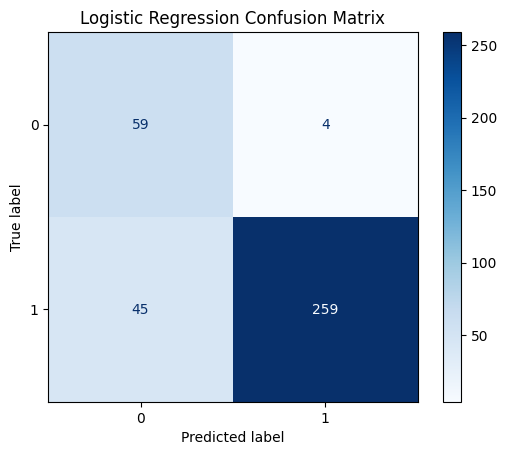

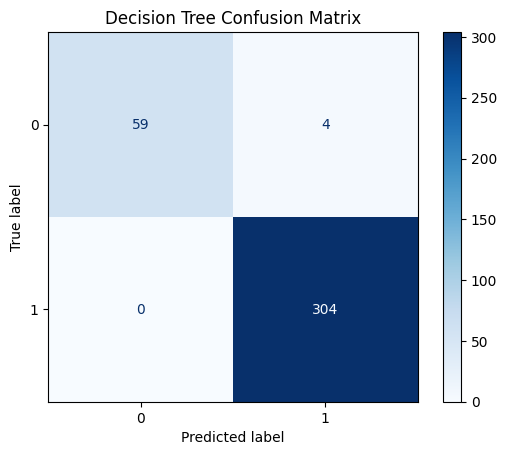

In [571]:
# Logistic Regression confusion matrix
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic)
disp_logistic.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Decision Tree confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_decisiontree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()
